<a href="https://colab.research.google.com/github/viveknagesh21/min/blob/main/nlp_disaster_tweets_using_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import Libraries

In [3]:
!pip install tensorflow
!pip install tensorflow_text
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, auc, accuracy_score
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Sequential , Model

import tensorflow_hub as hub
import tensorflow_text as text

import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 53.7 MB/s eta 0:00:00


## Data Collection

In [4]:
# Replace the URLs with the "Raw" URLs
train_url = "https://raw.githubusercontent.com/viveknagesh21/min/main/train.csv"
test_url = "https://raw.githubusercontent.com/viveknagesh21/min/main/test.csv"

# Read the CSV files
train = pd.read_csv(train_url)
test = pd.read_csv(test_url)

In [5]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


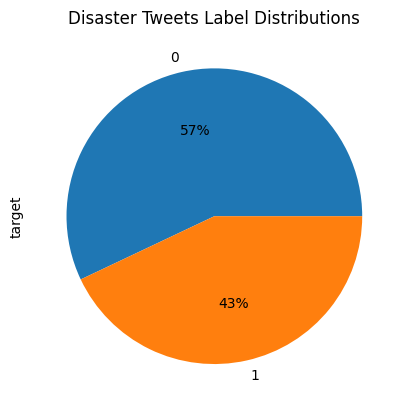

In [7]:
train.target.value_counts().plot(kind='pie',autopct="%.0f%%")
plt.title("Disaster Tweets Label Distributions")
plt.show()

## Split The Data For training and testing purpose

In [8]:
x_train , x_test , y_train , y_test = train_test_split(train['text'], train['target'], test_size=0.10)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6851,)
(762,)
(6851,)
(762,)


In [9]:
x_train

6966    @author_mike Amen today is the Day of Salvatio...
2723    ÛÏRichmond Coaches were devastated to hear of...
4629    Enter the world of extreme diving ÛÓ 9 storie...
2912    I am that girl on tv that sadly turns her musi...
7533    Wreckage 'Conclusively Confirmed' as From MH37...
                              ...                        
7531    Check out 'Malaysia Confirms Plane Wreckage Is...
6538    Electricity cant stop scofield. Nigga survived...
69      Accident center lane blocked in #SantaClara on...
1200      kou is like [CASH REGISTER] [BUILDINGS BURNING]
6774    Tornado has to make the playoffs. They have 3 ...
Name: text, Length: 6851, dtype: object

In [10]:
y_train

6966    1
2723    1
4629    0
2912    0
7533    1
       ..
7531    1
6538    0
69      1
1200    0
6774    0
Name: target, Length: 6851, dtype: int64

## Creating Model Using  BERT


In [11]:
## Create Model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string , name='input')
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
preprocessed_text = bert_preprocess(text_input)

bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")
outputs = bert_encoder(preprocessed_text)
net = outputs['pooled_output']

l = tf.keras.layers.Dropout(0.3 , name="dropout")(net)
d = tf.keras.layers.Dense(1 , activation='sigmoid' , name='output')(l)

model = tf.keras.Model(inputs=[text_input] , outputs=[d])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input[0][0]']               
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

history = model.fit(x_train, y_train , batch_size=300 ,
                    epochs=20 , validation_data=(x_test, y_test))

Epoch 1/20
23/23 [==============================] - 146s 6s/step - loss: 0.7119 - accuracy: 0.5475 - val_loss: 0.6332 - val_accuracy: 0.6430
Epoch 2/20
23/23 [==============================] - 141s 6s/step - loss: 0.6561 - accuracy: 0.6205 - val_loss: 0.6140 - val_accuracy: 0.6588
Epoch 3/20
23/23 [==============================] - 141s 6s/step - loss: 0.6449 - accuracy: 0.6390 - val_loss: 0.6020 - val_accuracy: 0.6837
Epoch 4/20
23/23 [==============================] - 133s 6s/step - loss: 0.6345 - accuracy: 0.6506 - val_loss: 0.6030 - val_accuracy: 0.6693
Epoch 5/20
23/23 [==============================] - 139s 6s/step - loss: 0.6253 - accuracy: 0.6533 - val_loss: 0.5853 - val_accuracy: 0.7021
Epoch 6/20
23/23 [==============================] - 140s 6s/step - loss: 0.6179 - accuracy: 0.6655 - val_loss: 0.5821 - val_accuracy: 0.6837
Epoch 7/20
23/23 [==============================] - 141s 6s/step - loss: 0.6073 - accuracy: 0.6809 - val_loss: 0.5730 - val_accuracy: 0.7100
Epoch 8/20
23

## Model Evaluation

In [13]:
loss , acc = model.evaluate(x_test,y_test)
print("Loss on Test data:",loss)
print("Accuracy on Test data:",acc)
print()
loss , acc = model.evaluate(x_train,y_train)
print("Loss on Test data:",loss)
print("Accuracy on Test data:",acc)

24/24 [==============================] - 8s 337ms/step - loss: 0.5310 - accuracy: 0.7375
Loss on Test data: 0.5310457348823547
Accuracy on Test data: 0.7375327944755554

215/215 [==============================] - 74s 342ms/step - loss: 0.5474 - accuracy: 0.7428
Loss on Test data: 0.5474206805229187
Accuracy on Test data: 0.7428112626075745


In [ ]:
y_pred = model.predict(x_test)
y_pred_label = [1 if i>=0.5 else 0 for i in y_pred]

20/24 [========================>.....] - ETA: 1s

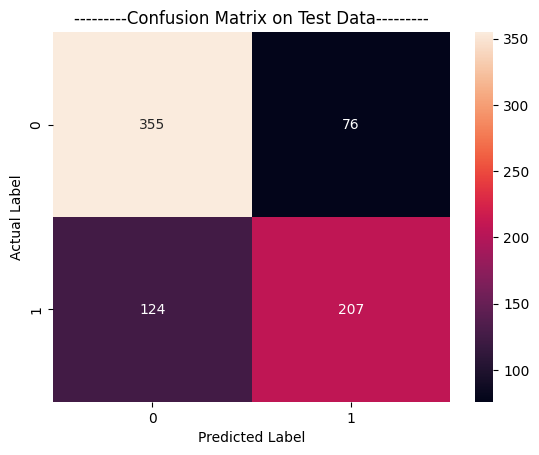

In [15]:
sns.heatmap(confusion_matrix(y_test,y_pred_label),annot=True,fmt='.0f',)
plt.title("---------Confusion Matrix on Test Data---------")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

In [16]:
# Model Evaluation on Test Data

print("Confusion Matrix:",confusion_matrix(y_test,y_pred_label))
print()
print("Classification Report:",classification_report(y_test,y_pred_label))

Confusion Matrix: [[355  76]
 [124 207]]

Classification Report:               precision    recall  f1-score   support

           0       0.74      0.82      0.78       431
           1       0.73      0.63      0.67       331

    accuracy                           0.74       762
   macro avg       0.74      0.72      0.73       762
weighted avg       0.74      0.74      0.73       762



## Sumbission File

In [17]:
predictions = model.predict(test['text'])
predictions = [1 if i>=0.5 else 0 for i in predictions]

102/102 [==============================] - 35s 345ms/step


In [ ]:
predictions[:5]

In [ ]:
df = pd.DataFrame()
df['id'] = test['id']
df['target'] = predictions

In [20]:
df    # This is Submission File

,id,target
0,0,0
1,2,0
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,1


,id,target
0,0,0
1,2,0
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,0
3260,10868,1
3261,10874,1


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.tight_layout()

from matplotlib import pyplot as plt
_df_1['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.tight_layout()

from matplotlib import pyplot as plt
_df_2['target'].plot(kind='hist', bins=20, title='target')
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.tight_layout()

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
_df_3.plot(kind='scatter', x='index', y='id', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.tight_layout()

from matplotlib import pyplot as plt
plt.figure(figsize=(6, 6))
_df_4.plot(kind='scatter', x='id', y='target', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
plt.tight_layout()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['target']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
plt.ylabel('target')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['id']
  ys = series['target']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
plt.ylabel('target')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['id']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'id'}, axis=1)
              .sort_values('id', ascending=True))
  xs = counted['id']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('id', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('id')
plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

from matplotlib import pyplot as plt
_df_10['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()

from matplotlib import pyplot as plt
_df_11['target'].plot(kind='line', figsize=(8, 4), title='target')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.tight_layout()